In [3]:
import psycopg2
import pandas as pd
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# loading the env to get database credentials
load_dotenv()

True

In [5]:
# Getting the db credentials from .env file
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD  = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')

In [6]:
# connecting to the database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST
)
cur = conn.cursor()

## 1. What is the most common type of crime (based on 'Crm Cd Desc') in each area (based on 'AREA NAME')?

In [ ]:
# sql query required
sql_query = '''
WITH crime_counts AS (
select area_name, crm_cd_desc,
count(*) as count_per_area_per_crime,
ROW_NUMBER() OVER (PARTITION BY area_name ORDER BY COUNT(*) DESC) as rn
from la_crime
group by area_name,crm_cd_desc
)

SELECT area_name, crm_cd_desc as most_common_crime, count_per_area_per_crime
from crime_counts
    where rn=1;
'''
df = pd.read_sql_query(sql_query, conn)


In [12]:
df

,area_name,most_common_crime,count_per_area_per_crime
0,77th Street,VEHICLE - STOLEN,5671
1,Central,BURGLARY FROM VEHICLE,6552
2,Devonshire,VEHICLE - STOLEN,2706
3,Foothill,VEHICLE - STOLEN,3002
4,Harbor,VEHICLE - STOLEN,4033
5,Hollenbeck,VEHICLE - STOLEN,4295
6,Hollywood,BATTERY - SIMPLE ASSAULT,3387
7,Mission,VEHICLE - STOLEN,3861
8,N Hollywood,VEHICLE - STOLEN,3301
9,Newton,VEHICLE - STOLEN,5486


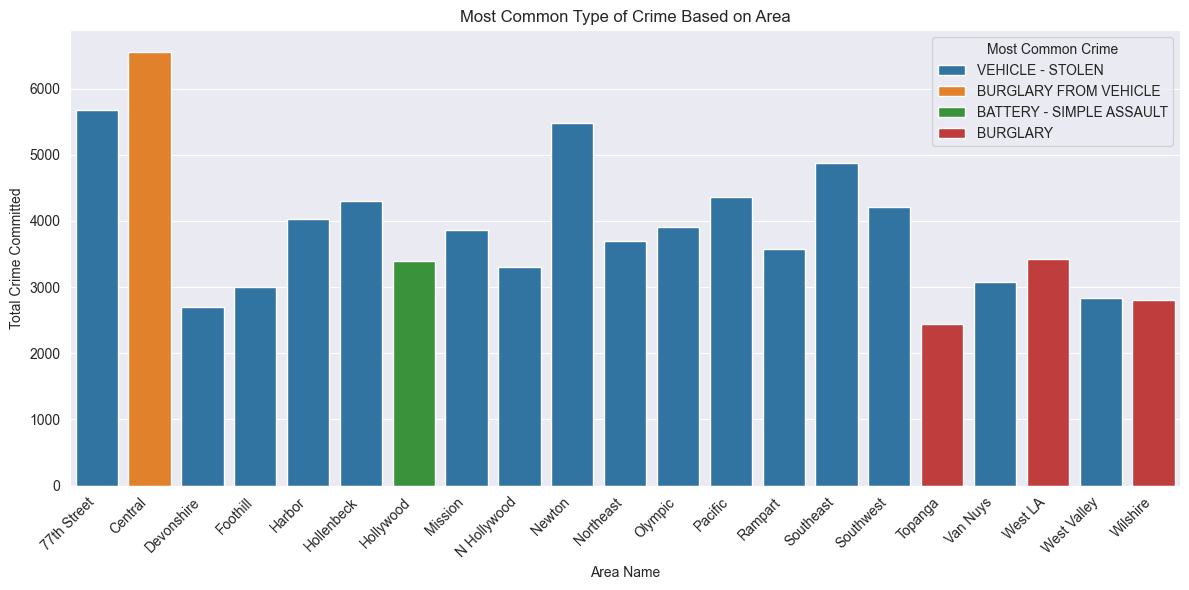

In [35]:
plt.figure(figsize=(12,6))
ax = sns.barplot(df,x="area_name",y="count_per_area_per_crime", hue="most_common_crime",dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(title="Most Common Crime")
plt.ylabel("Total Crime Committed")
plt.xlabel("Area Name")
plt.title("Most Common Type of Crime Based on Area")
plt.tight_layout()
plt.show()

## 2. How does the time of occurrence ('TIME OCC') relate to the type of crime ('Crm Cd Desc')? Are certain crimes more likely at certain times of day?

In [ ]:
sql_query = '''
SELECT
crm_cd_desc,
CASE
	WHEN EXTRACT(HOUR FROM time_occ) BETWEEN 0 AND 5 THEN 'Night'
	WHEN EXTRACT(HOUR FROM time_occ) BETWEEN 6 AND 11 THEN 'Morning'
	WHEN EXTRACT(HOUR FROM time_occ) BETWEEN 12 AND 17 THEN 'Afternoon'
	ELSE 'Evening'
END as time_period,
count(*) as crime_count
from la_crime
group by crm_cd_desc, time_period
order by crm_cd_desc, crime_count desc;
'''
df = pd.read_sql_query(sql_query, conn)

In [37]:
df

,crm_cd_desc,time_period,crime_count
0,ARSON,Night,609
1,ARSON,Evening,534
2,ARSON,Afternoon,432
3,ARSON,Morning,384
4,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,Evening,415
...,...,...,...
514,VIOLATION OF TEMPORARY RESTRAINING ORDER,Night,55
515,WEAPONS POSSESSION/BOMBING,Evening,14
516,WEAPONS POSSESSION/BOMBING,Night,6
517,WEAPONS POSSESSION/BOMBING,Afternoon,5


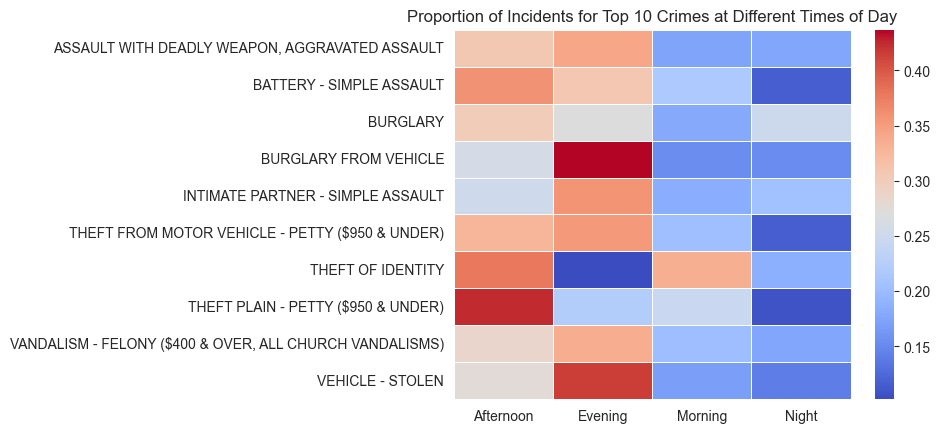

In [84]:

# Calculate total incidents for each crime
df['Total'] = df.groupby('crm_cd_desc')['crime_count'].transform('sum')

# Find the top 10 crimes
top_10_crimes = df.groupby('crm_cd_desc')['Total'].mean().nlargest(10).index

# Filter your dataframe to only include these top 10 crimes, and explicitly create a copy
df_top_10 = df[df['crm_cd_desc'].isin(top_10_crimes)].copy()

# Calculate the proportion of incidents for each time of day and crime type
df_top_10['Proportion'] = df_top_10['crime_count'] / df_top_10['Total']

# Pivot the dataframe to get it in the right format for a heatmap
pivot_top_10 = df_top_10.pivot_table(values='Proportion', index='crm_cd_desc', columns='time_period')

# Plot a heatmap
plt.figure()
sns.heatmap(pivot_top_10, cmap='coolwarm', linewidths=0.5)
plt.xlabel("")
plt.ylabel("")
plt.title('Proportion of Incidents for Top 10 Crimes at Different Times of Day')
plt.show()